In [14]:
# import model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import model
from keras.models import load_model, Model
model = load_model('./model-data/model.h5')

In [15]:
# Summary of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 262, 262, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
# Using training data for the embedding space + recommendations 
# NOTE: we don't use generator for this because we want to store the file paths as well
train_df = pd.read_csv("./split-data/train_new.csv")

Found 15889 validated image filenames belonging to 46 classes.


In [27]:
# remove the last layer for feature extraction
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('dense_4').output)

In [ ]:
import os 
from tensorflow.keras.preprocessing.image import load_img, img_to_array

features_list = []
paths_list = []
labels_list = []

# Iterate over each row in the DataFrame
for idx, row in train_df.iterrows():
    img_path = os.path.join('./dataset', row['img_path'])
    label = row['category']
    
    # Load and preprocess the image
    img = load_img(img_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # rescale
    img_array = np.expand_dims(img_array, axis=0)
    
    # Extract features
    features = feature_extractor.predict(img_array, verbose=0)
    
    # Store the results
    features_list.append(features)
    labels_list.append(label)
    paths_list.append(img_path)
    
# Convert lists to numpy arrays
features_array = np.array(features_list)
labels_array = np.array(labels_list)
paths_array = np.array(paths_list)

# Convert lists to numpy arrays
features_array = np.concatenate(features_list, axis=0)
labels_array = np.array(labels_list)
paths_array = np.array(paths_list)


15889
15889
15889


In [70]:
# Save the data
np.savez("model-data/features-data.npz", features=features_array, labels=labels_array, paths=paths_array)

In [71]:
# Load saved features
embedding_data = np.load("model-data/features-data.npz", mmap_mode='r')
features = embedding_data["features"]
labels = embedding_data["labels"]
paths = embedding_data["paths"]


In [ ]:
# Using FAISS for similarity search
import faiss

# Get vector dimension of features
d = features.shape[1] 

# Create Faiss index (using L2 distance for exact search)
index = faiss.IndexFlatL2(d)
# Normalize feature vectors
norms = np.linalg.norm(features, axis=1, keepdims=True)
normalized_features = features / norms
index.add(normalized_features)

print(f"Number of vectors in the index: {index.ntotal}")

Number of vectors in the index: 15889


Random Image:
Path: ./dataset/img/Tribal_Print_V-Back_Kaftan/img_00000025.jpg


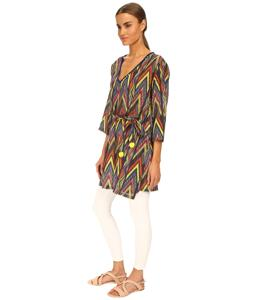

Top 5 neighbors:
Path: ./dataset/img/Tribal_Print_V-Back_Kaftan/img_00000011.jpg


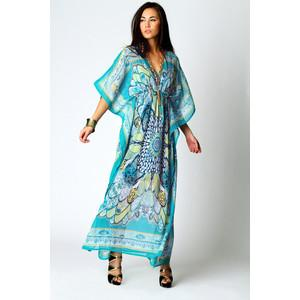

Matching category
Path: ./dataset/img/Paisley_Print_Kaftan/img_00000004.jpg


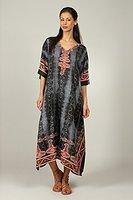

Matching category
Path: ./dataset/img/Abstract_Floral_Print_Poncho/img_00000013.jpg


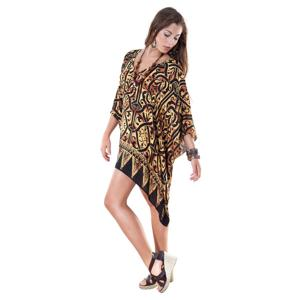

Path: ./dataset/img/Tribal_Print_Kimono/img_00000010.jpg


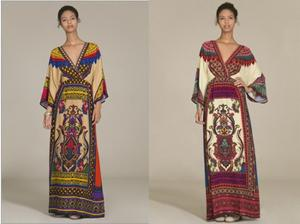

Path: ./dataset/img/Paisley_Print_Kaftan/img_00000013.jpg


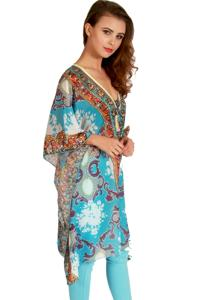

Matching category
% categorically accurate : 0.6


In [102]:
# QUALTITATIVE ANALYSIS
# Retrieve similar images for a random image from the embedding space
# Check for 1) categorically similarity and 2) visually similarity

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from IPython.display import display, Image
import random

random_index = random.randint(0, len(features))
random_image_path = paths[random_index]
random_label = labels[random_index]
random_features = features[random_index].reshape(1, -1)

# number of neighbors to retrieve 
k = 5
# retrieve k + 1 neighbors to ignore the same embedding
distances, indices = index.search(random_features, k + 1)

# ignore the first element as that would be the same as the random sample
similar_image_paths = [paths[idx] for idx in indices[0]][1:]
similar_image_labels = [labels[idx] for idx in indices[0]][1:]

# Display the original and similar images
print("Random Image:\nPath: " + random_image_path)
display(Image(filename = random_image_path))
# Calculate the % of correct category
correct_category = 0
print("Top " + str(k) + " neighbors:")
for label, path in zip(similar_image_labels, similar_image_paths):
    print("Path: " + path)   
    display(Image(filename=path))
    if np.array_equal(random_label, label):
        print("Matching category")
        correct_category += 1
print("% categorically accurate : " + str(correct_category/(k)))

In [113]:
# QUANTITATIVE ANALYSIS
# Calculate the average category matching percentage within the embedding space
k = 5
num_samples = 3000
sample_indices = np.random.choice(len(features), size=num_samples, replace=False)
sample_features = features[sample_indices]

# Search for neighbors
_, indices = index.search(sample_features, k+1)

# Calculate the accuracy
accuracy_sum = 0.0
for i, idxs in enumerate(indices):
    neighbor_indices = idxs[1:] 
    original_label = labels[sample_indices[i]]
    neighbor_labels = labels[neighbor_indices]
    category_matches = np.sum(neighbor_labels == original_label)
    accuracy_sum += (category_matches / k) 

# Compute the average accuracy across all sampled points
average_accuracy = accuracy_sum / num_samples
print("Average category matching percentage:", average_accuracy)


Average category matching percentage: 0.3529333333333343


In [86]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the test data
test_df = pd.read_csv("./split-data/test_new.csv")
# only use use 50 images from each category for testing 
test_df = test_df.groupby('category').head(50)

# Create the test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./dataset",
    x_col="img_path",
    y_col="category",
    batch_size=64,
    shuffle=False,
    target_size=(256, 256),
    # We can keep categories raw as we are not training the model
    class_mode="raw",
    workers=4
)

# Extract features and labels from the test set
test_features_list = []
test_labels_list = []
num_batches_test = len(test_generator)

for i in range(num_batches_test):
    batch_x, batch_y = next(test_generator)
    batch_features = feature_extractor.predict(batch_x)
    test_features_list.append(batch_features)
    test_labels_list.append(batch_y)

# Normalize the test features
test_features = np.concatenate(test_features_list, axis=0)
norms = np.linalg.norm(test_features, axis=1, keepdims=True)
normalized_test_features = test_features / norms

test_labels = np.concatenate(test_labels_list, axis=0)


Found 1787 validated image filenames.
2/2 [==============================] - 3s 1s/step


In [117]:
# QUANTITATIVE ANALYSIS
# Calculate the average category matching percentage for images outside the embedding space
k = 5
distances, indices = index.search(normalized_test_features, k)

accuracy_sum = 0.0
num_samples = len(test_features)
for i in range(num_samples):
    original_label = test_labels[i]
    neighbor_labels = labels[indices[i]] 
    category_matches = np.sum(neighbor_labels == original_label)
    accuracy_sum += (category_matches / k)

average_accuracy = accuracy_sum / num_samples
print("Average category matching percentage on test set:", average_accuracy)

Average category matching percentage on test set: 0.3198656966983769
